# mount drive

In [1]:
use_colaboratory = True
if use_colaboratory:
    import os
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/tabular-playground-series-mar-2022/notebook')

Mounted at /content/drive


# EDA

In [2]:
# import packages
import datetime
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [ ]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")

### summary of data

In [ ]:
train.head(3)

,time,x,y,direction,congestion
row_id,,,,,
0,1991-04-01 00:00:00,0,0,EB,70
1,1991-04-01 00:00:00,0,0,NB,49
2,1991-04-01 00:00:00,0,0,SB,24


In [ ]:
test.head(3)

,time,x,y,direction
row_id,,,,
848835,1991-09-30 12:00:00,0,0,EB
848836,1991-09-30 12:00:00,0,0,NB
848837,1991-09-30 12:00:00,0,0,SB


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 848835 entries, 0 to 848834
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time        848835 non-null  object
 1   x           848835 non-null  int64 
 2   y           848835 non-null  int64 
 3   direction   848835 non-null  object
 4   congestion  848835 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 38.9+ MB


In [ ]:
train.describe()

,x,y,congestion
count,848835.000000,848835.000000,848835.000000
mean,1.138462,1.630769,47.815305
std,0.801478,1.089379,16.799392
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,35.000000
50%,1.000000,2.000000,47.000000
75%,2.000000,3.000000,60.000000
max,2.000000,3.000000,100.000000


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2340 entries, 848835 to 851174
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   time       2340 non-null   object
 1   x          2340 non-null   int64 
 2   y          2340 non-null   int64 
 3   direction  2340 non-null   object
dtypes: int64(2), object(2)
memory usage: 91.4+ KB


In [ ]:
test.describe()

,x,y
count,2340.000000,2340.000000
mean,1.138462,1.630769
std,0.801649,1.089611
min,0.000000,0.000000
25%,0.000000,1.000000
50%,1.000000,2.000000
75%,2.000000,3.000000
max,2.000000,3.000000


### create features

In [ ]:
# add features
data = pd.concat([train, test])
data["time"] = pd.to_datetime(data["time"])
data["month"] = data["time"].dt.month
data["weekofyear"] = data["time"].dt.weekofyear
data["day"] = data["time"].dt.day
data["dayofyear"] = data["time"].dt.dayofyear
data["weekday"] = data["time"].dt.weekday
data["hour"] = data["time"].dt.hour
data["minute"] = data["time"].dt.minute
data["quarter"] = data["time"].dt.quarter
data["weekend"] = data["weekday"] >= 5
data["am"] = data["hour"] < 12
data["dir_xy"] = data["direction"].map({'EB':(1,0), 'NB':(0,1), 'SB':(0,-1), 'WB':(-1,0), 'NE':(1,1), 'SW':(-1,-1), 'NW':(-1,1), 'SE':(1,-1)})
data['time_id'] = (((data["dayofyear"] - 1) * 24 * 60 + data["hour"] * 60 + data["minute"]) / 20).astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [ ]:
# split train and test data
train = data.iloc[:len(train)]
test = data.iloc[-len(test):]
print("lenght of train: {}".format(len(train)))
print("lenght of test: {}".format(len(test)))

lenght of train: 848835
lenght of test: 2340


### period of train and test

train: 1991-04-01 00:00:00 - 1991-09-30 11:40:00
test: 1991-09-30 12:00:00 - 1991-09-30 23:40:00





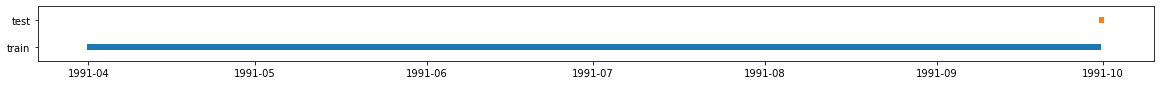

In [ ]:
fig = plt.figure(figsize=(20, 1))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(train["time"], np.zeros(len(train)), marker="|")
ax.scatter(test["time"], np.ones(len(test)), marker="|")
ax.set_ylim([-0.5, 1.5])
ax.set_yticks([0, 1])
ax.set_yticklabels(["train", "test"])
print("train: {} - {}".format(train.time.iloc[0], train.time.iloc[-1]))
print("test: {} - {}".format(test.time.iloc[0], test.time.iloc[-1]))
print("\n\n")

testはtrainの直後の期間

### roadways

In [ ]:
loc_dir = train.groupby(["x", "y"])["dir_xy"].unique().reset_index()
loc_dir["num_dir"] = loc_dir["dir_xy"].map(lambda x: len(x))
print(loc_dir, end="\n\n")
print("Num of roadways: {}".format(loc_dir["num_dir"].sum()))

    x  y                                             dir_xy  num_dir
0   0  0                          [(1, 0), (0, 1), (0, -1)]        3
1   0  1                 [(1, 0), (0, 1), (0, -1), (-1, 0)]        4
2   0  2                 [(1, 0), (0, 1), (0, -1), (-1, 0)]        4
3   0  3  [(1, 0), (0, 1), (1, 1), (0, -1), (-1, -1), (-...        6
4   1  0  [(1, 0), (0, 1), (1, 1), (0, -1), (-1, -1), (-...        6
5   1  1                 [(1, 0), (0, 1), (0, -1), (-1, 0)]        4
6   1  2  [(1, 0), (0, 1), (1, 1), (0, -1), (-1, -1), (-...        6
7   1  3  [(1, 0), (0, 1), (1, 1), (0, -1), (-1, -1), (-...        6
8   2  0                 [(1, 0), (0, 1), (0, -1), (-1, 0)]        4
9   2  1  [(1, 0), (0, 1), (1, 1), (-1, 1), (0, -1), (1,...        8
10  2  2  [(1, 0), (0, 1), (1, 1), (-1, 1), (0, -1), (1,...        8
11  2  3  [(1, 0), (0, 1), (1, 1), (0, -1), (-1, -1), (-...        6

Num of roadways: 65


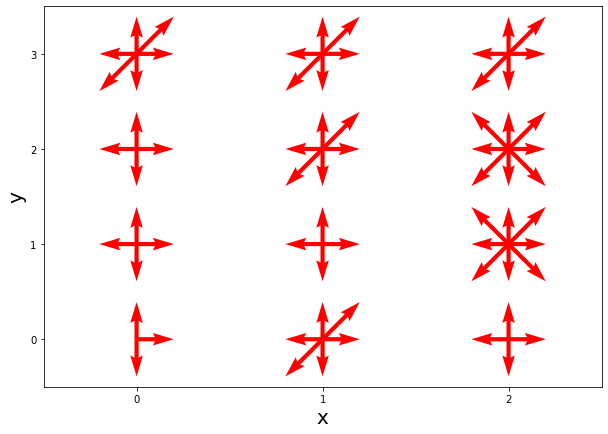

In [ ]:
plt.figure(figsize=(10, 7))

for idx, row in loc_dir.iterrows():
    origin = np.repeat([[row.x], [row.y]], row.num_dir, axis=1)
    V = np.array([t for t in row.dir_xy])
    plt.quiver(origin[0], origin[1], V[:,0], V[:,1], scale=15, color='red')
    
plt.xlim(-0.5,2.5)
plt.ylim(-0.5,3.5)
plt.xticks(loc_dir.x.unique())
plt.yticks(loc_dir.y.unique())
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)
plt.show()

### time

In [ ]:
print(train.groupby(["x", "y", "direction"])["congestion"].count())
recorded_instants = train.groupby(["x", "y", "direction"])["congestion"].count().iloc[0]
total_instants = int(train.time_id.max() - train.time_id.min()+1)
print("Total time instants within the observation period: {}".format(total_instants))
print("Missing instants: {}".format(total_instants - recorded_instants))

x  y  direction
0  0  EB           13059
      NB           13059
      SB           13059
   1  EB           13059
      NB           13059
                   ...  
2  3  NB           13059
      NE           13059
      SB           13059
      SW           13059
      WB           13059
Name: congestion, Length: 65, dtype: int64
Total time instants within the observation period: 13140
Missing instants: 81


In [ ]:
time = pd.DataFrame(pd.date_range("1991-04-01 00:00:00", "1991-09-30 11:40:00", freq="20Min"), columns=["time"])

dfs = []
for group in train.groupby(["x", "y", "direction"]):
    dfs.append(group[1].merge(time, on="time", how="right"))

train_new = pd.concat(dfs, axis=0).sort_values(["time", "x", "y", "direction"]).reset_index()
print("Missing row: \n{}".format(train_new.isna().sum()))

Missing row: 
index            0
time             0
x             5265
y             5265
direction     5265
congestion    5265
month         5265
weekofyear    5265
day           5265
dayofyear     5265
weekday       5265
hour          5265
minute        5265
quarter       5265
weekend       5265
am            5265
dir_xy        5265
time_id       5265
dtype: int64


### Target: congestion level

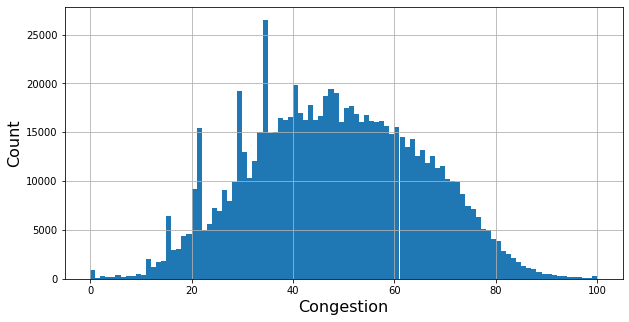

In [ ]:
# histgram
plt.figure(figsize=(10, 5))
train.congestion.hist(bins=100)
plt.xlabel("Congestion", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.show()

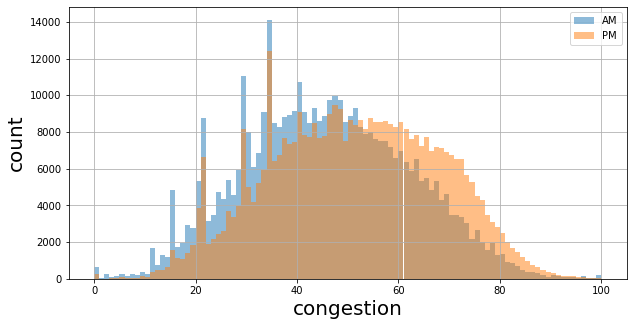

In [ ]:
# am vs pm
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 1, 1)
train[train["am"]]["congestion"].hist(bins=100, label="AM", alpha=0.5)
train[~train["am"]]["congestion"].hist(bins=100, label="PM", alpha=0.5)
ax.set_xlabel("congestion", fontsize=20)
ax.set_ylabel("count", fontsize=20)
ax.legend()
fig.show()

### Histgrams for each roadway

In [ ]:
xs = train.x.unique()
ys = train.y.unique()
direction = train.direction.unique()

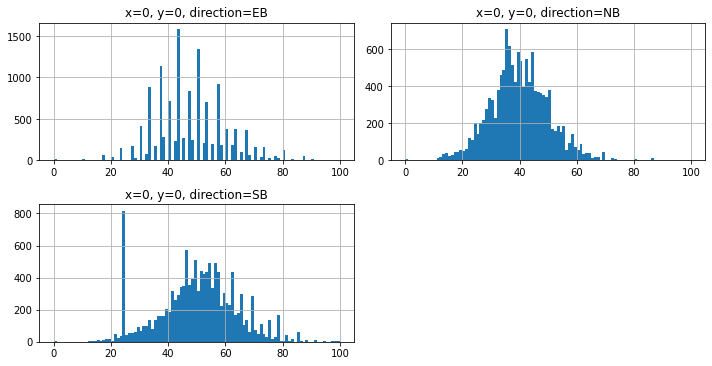

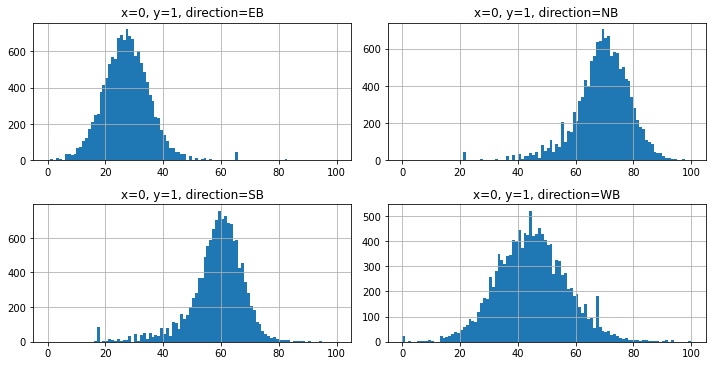

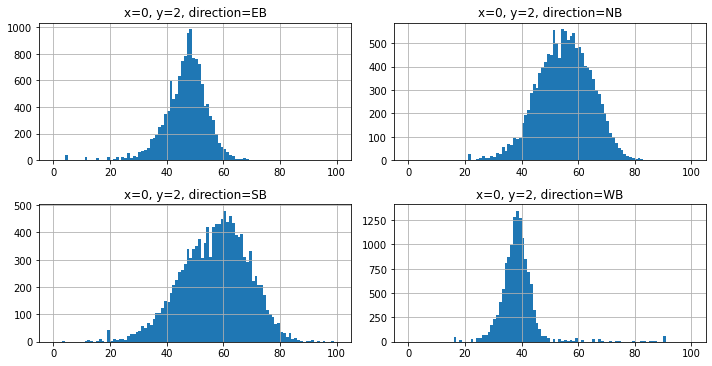

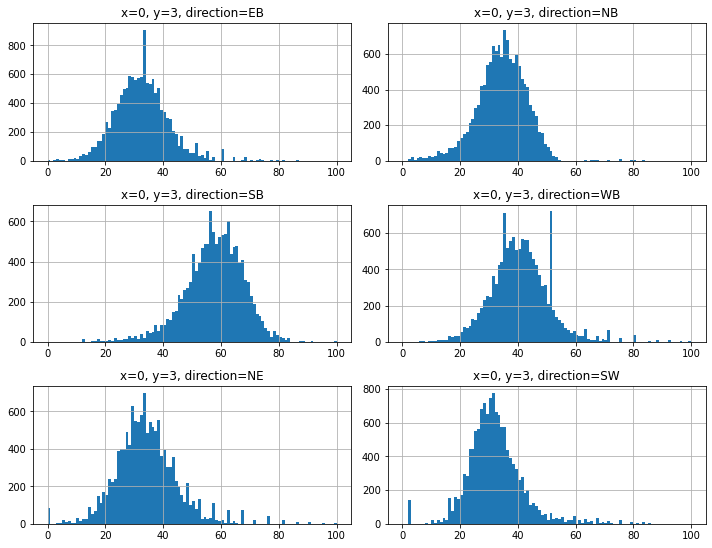

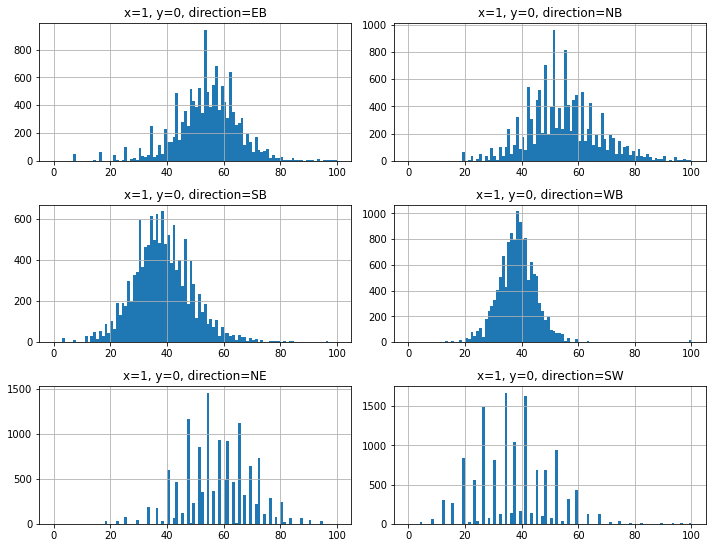

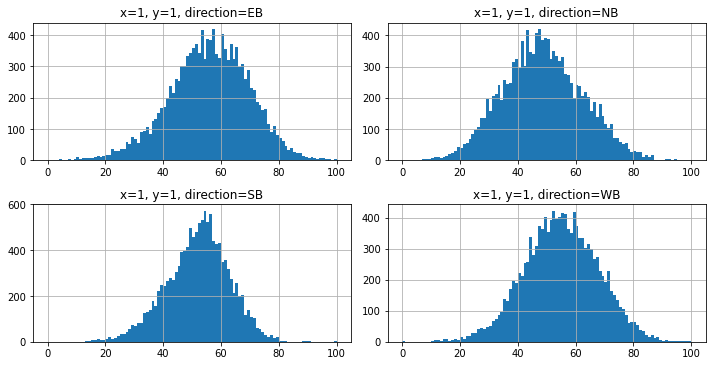

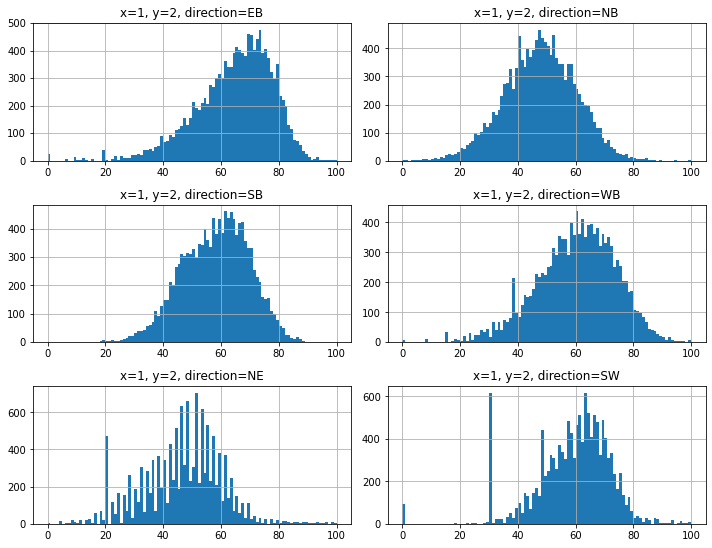

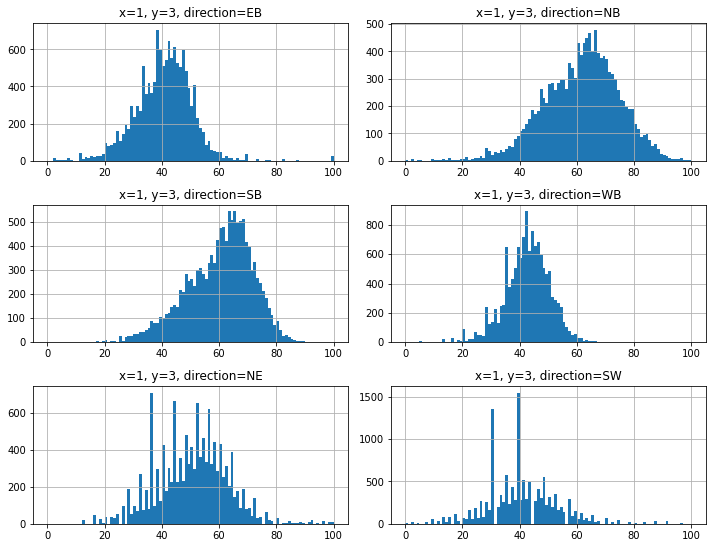

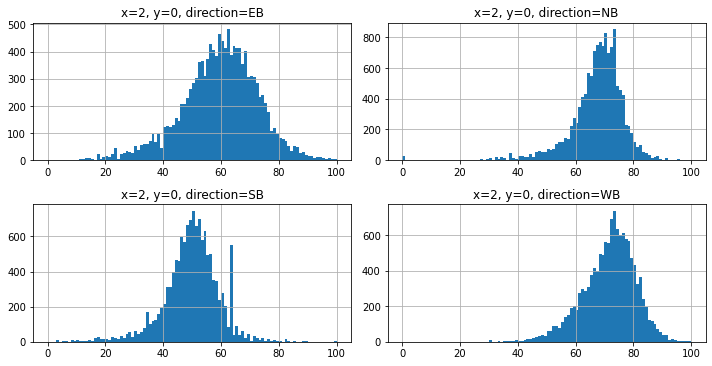

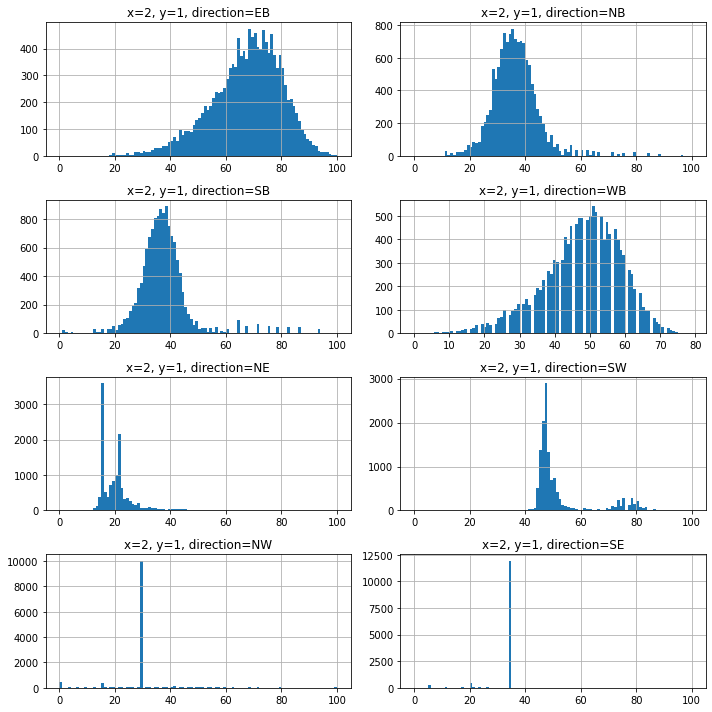

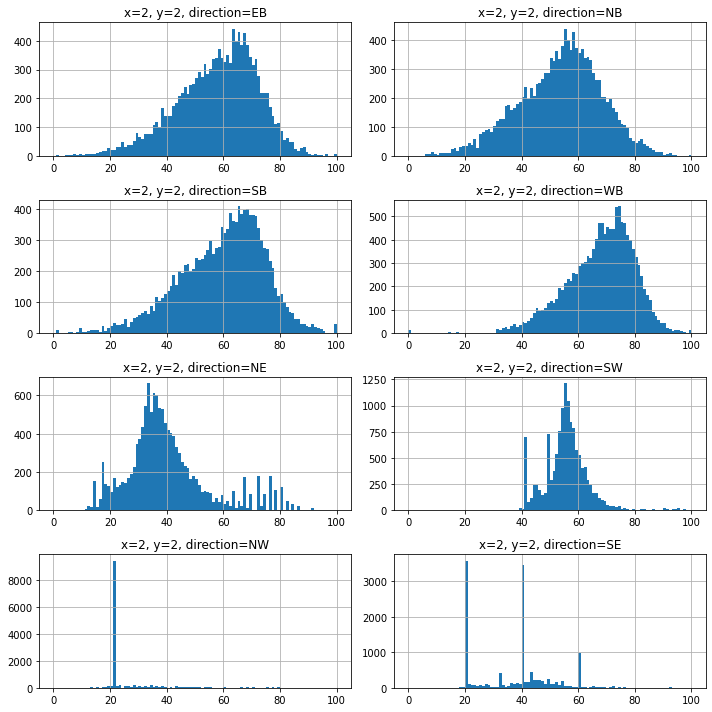

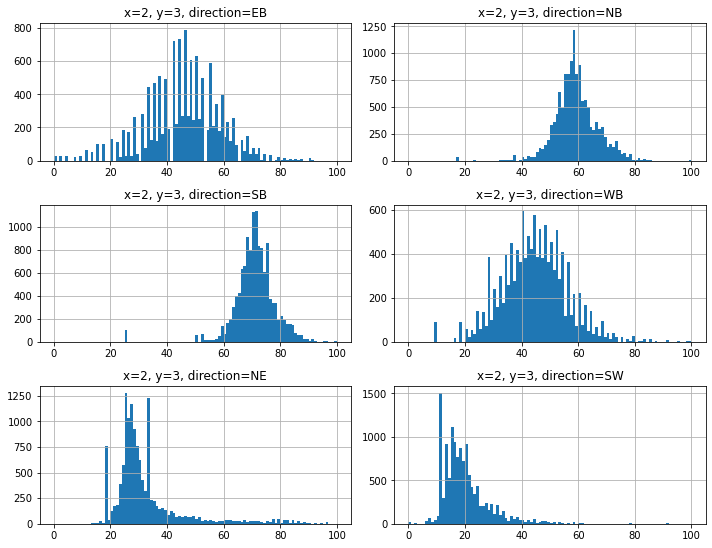

In [ ]:
for x in xs:
    for y in ys:
        plt.figure(figsize=(10, 10))
        for idx, dir in enumerate(direction):
            # extract data for each location and direction
            df = train[(train.x == x) & (train.y == y) & (train.direction == dir)]
            # pass combinations don't exist
            if df.shape[0] == 0:
                continue
            
            plt.subplot(4, 2, idx+1)
            df.congestion.hist(bins=100)
            plt.title("x={}, y={}, direction={}".format(x, y, dir))
            plt.tight_layout()

        plt.show()
        print("\n\n")

In [ ]:
for x in xs:
    for y in ys:
        df = train[(train.x == x) & (train.y == y)].groupby("direction").congestion.count()
        print("==== location: x{} y{} ====".format(x, y))
        print(df)
        print("\n")

==== location: x0 y0 ====
direction
EB    13059
NB    13059
SB    13059
Name: congestion, dtype: int64


==== location: x0 y1 ====
direction
EB    13059
NB    13059
SB    13059
WB    13059
Name: congestion, dtype: int64


==== location: x0 y2 ====
direction
EB    13059
NB    13059
SB    13059
WB    13059
Name: congestion, dtype: int64


==== location: x0 y3 ====
direction
EB    13059
NB    13059
NE    13059
SB    13059
SW    13059
WB    13059
Name: congestion, dtype: int64


==== location: x1 y0 ====
direction
EB    13059
NB    13059
NE    13059
SB    13059
SW    13059
WB    13059
Name: congestion, dtype: int64


==== location: x1 y1 ====
direction
EB    13059
NB    13059
SB    13059
WB    13059
Name: congestion, dtype: int64


==== location: x1 y2 ====
direction
EB    13059
NB    13059
NE    13059
SB    13059
SW    13059
WB    13059
Name: congestion, dtype: int64


==== location: x1 y3 ====
direction
EB    13059
NB    13059
NE    13059
SB    13059
SW    13059
WB    13059
Name: congest

### Correlation between 12 locations

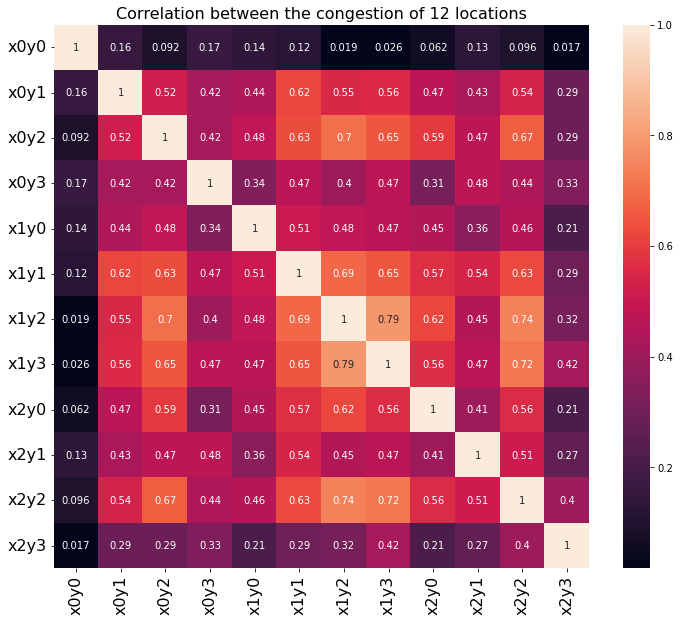

In [ ]:
dfs = []
columns = []
for x in xs:
    for y in ys:
        df = train[(train.x == x) & (train.y == y)].groupby("time").congestion.mean().to_list()
        dfs.append(df)
        columns.append("x{}y{}".format(x, y))
location_congestions = pd.DataFrame(np.array(dfs).T, columns=columns)

plt.figure(figsize=(12,10))
sns.heatmap(location_congestions.corr(), annot=True)
plt.title('Correlation between the congestion of 12 locations', fontsize=16)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(rotation=0, fontsize=16)
plt.show()

### Correlation between 12 locations at two consecutive instants

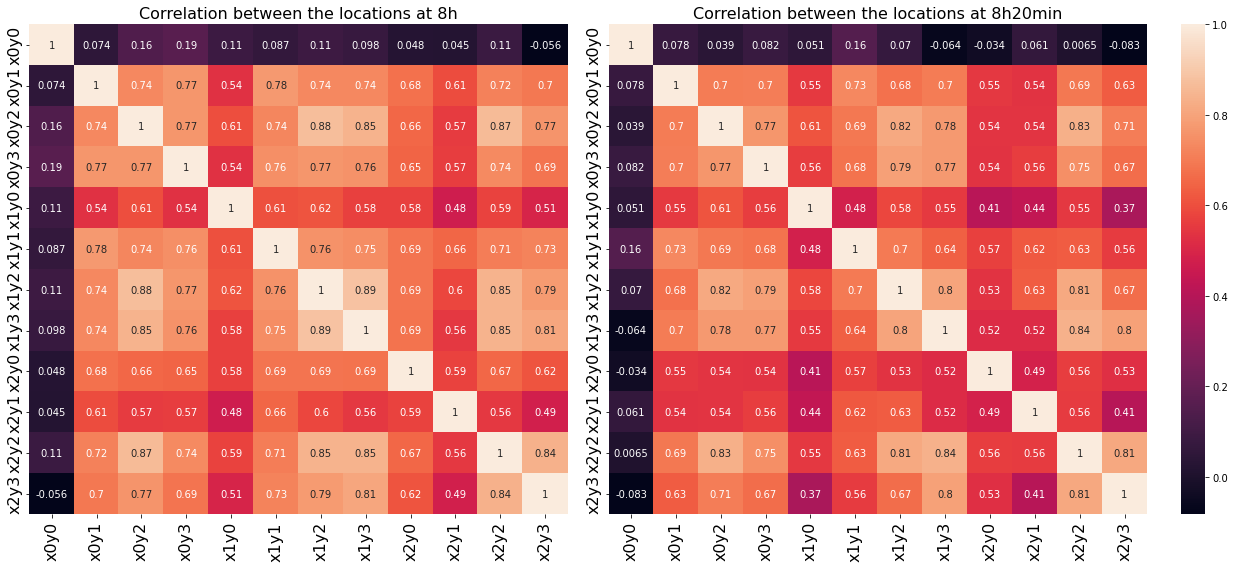

In [ ]:
plt.figure(figsize=(18, 8))

# At 8:00
dfs = []
columns = []
for x in xs:
    for y in ys:
        df = train[(train.x == x) & (train.y == y) & (train.hour == 8) & (train.minute == 0)]
        dfs.append(df.groupby("time").congestion.mean().tolist())
        columns.append("x{}y{}".format(x, y))
location_congestions = pd.DataFrame(np.array(dfs).T, columns=columns)

plt.subplot(1, 2, 1)
sns.heatmap(location_congestions.corr(), annot=True)
plt.title('Correlation between the locations at 8h', fontsize=16)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(rotation=90, fontsize=16)
plt.tight_layout()

# At 8:20
dfs = []
columns = []
for x in xs:
    for y in ys:
        df = train[(train.x == x) & (train.y == y) & (train.hour == 8) & (train.minute == 20)]
        dfs.append(df.groupby("time").congestion.mean().tolist())
        columns.append("x{}y{}".format(x, y))
location_congestions = pd.DataFrame(np.array(dfs).T, columns=columns)

plt.subplot(1, 2, 2)
sns.heatmap(location_congestions.corr(), annot=True)
plt.title('Correlation between the locations at 8h20min', fontsize=16)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(rotation=90, fontsize=16)
plt.tight_layout()

plt.show()

### Average congestion per month each location and direction

==== location: x0 y0 ====


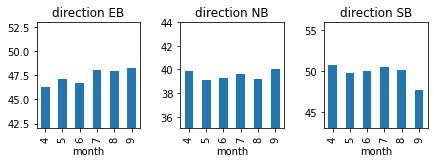

==== location: x0 y1 ====


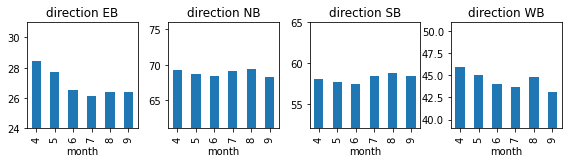

==== location: x0 y2 ====


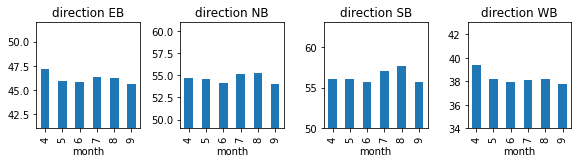

==== location: x0 y3 ====


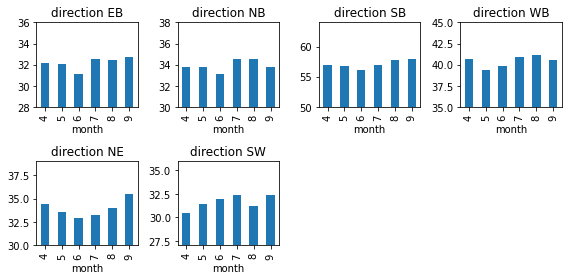

==== location: x1 y0 ====


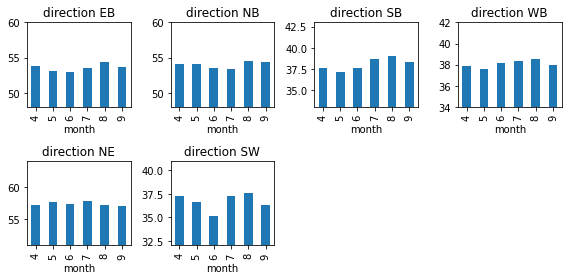

==== location: x1 y1 ====


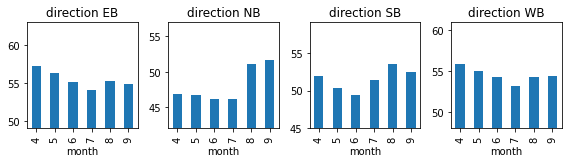

==== location: x1 y2 ====


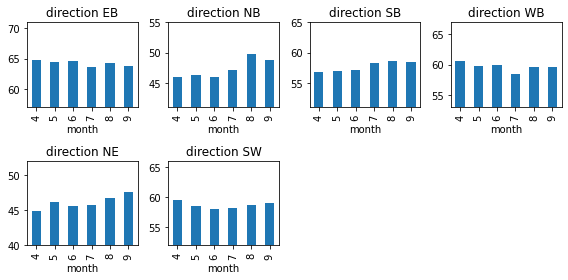

==== location: x1 y3 ====


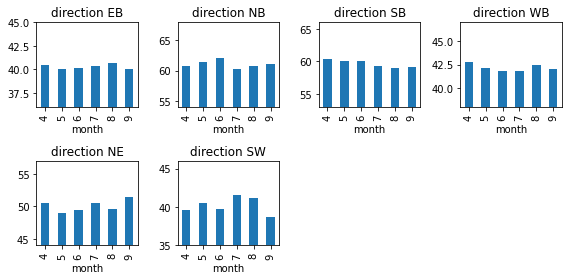

==== location: x2 y0 ====


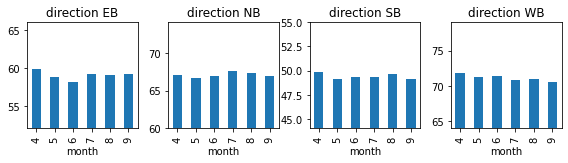

==== location: x2 y1 ====


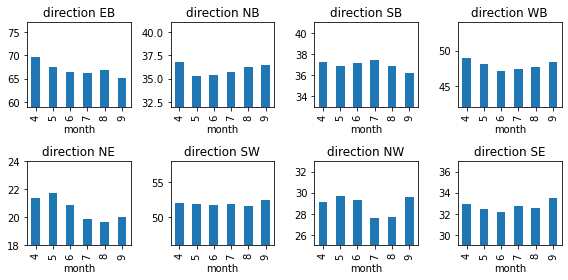

==== location: x2 y2 ====


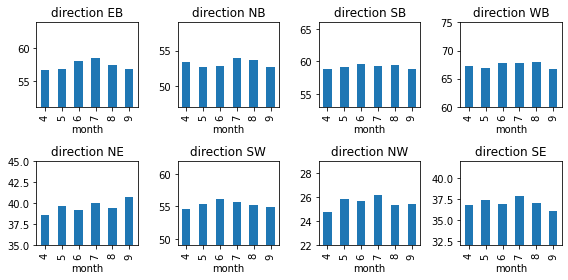

==== location: x2 y3 ====


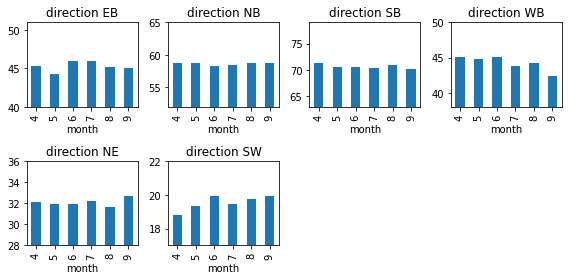

In [ ]:
for x in xs:
    for y in ys:
        print("==== location: x{} y{} ====".format(x, y))
        plt.figure(figsize=(8, 4))
        for i, dir in enumerate(direction):
            df = train[(train.x == x) & (train.y == y) & (train.direction == dir)].groupby("month").congestion.mean()
            if df.shape[0] == 0:
                continue

            plt.subplot(2, 4, i+1)
            df.plot(kind="bar")
            plt.title("direction {}".format(dir))
            plt.ylim(round(df.min()*0.9), round(df.max()*1.1))
        plt.tight_layout()
        plt.show()

### Average congestion per day each location and direction

==== location: x0 y0 ====


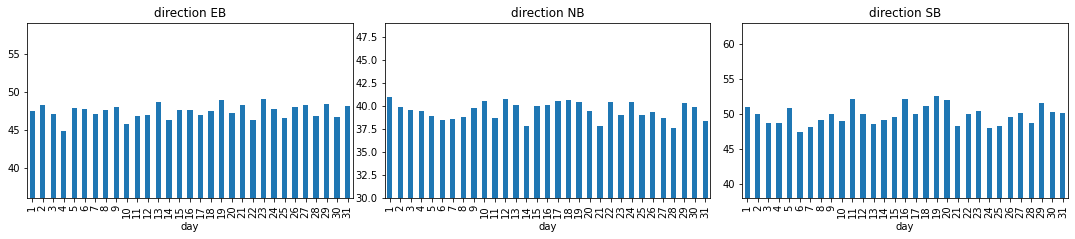

==== location: x0 y1 ====


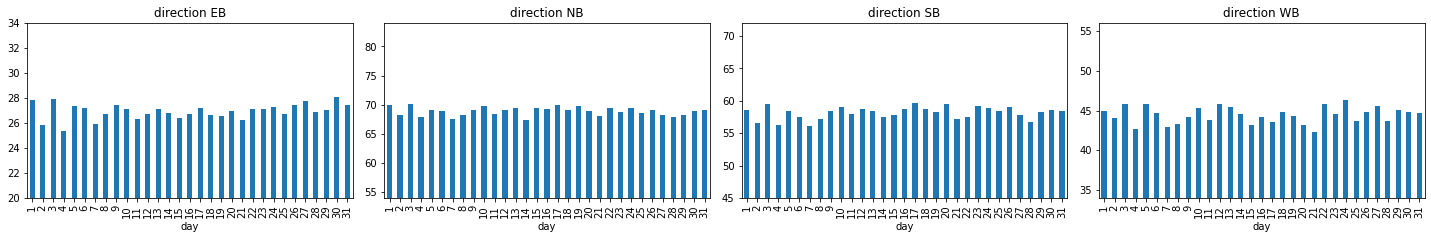

==== location: x0 y2 ====


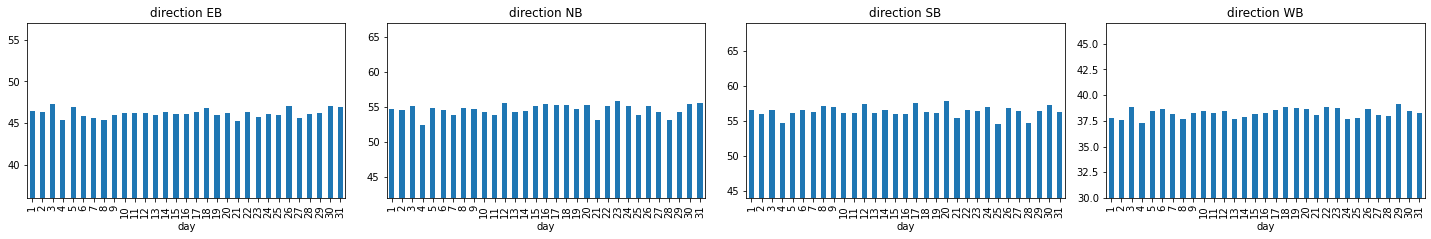

==== location: x0 y3 ====


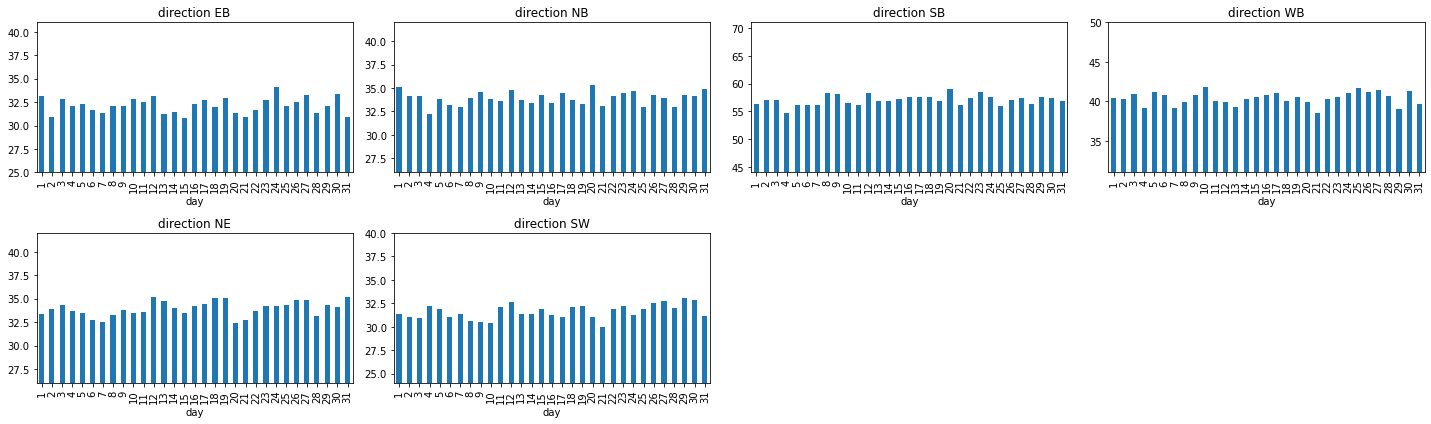

==== location: x1 y0 ====


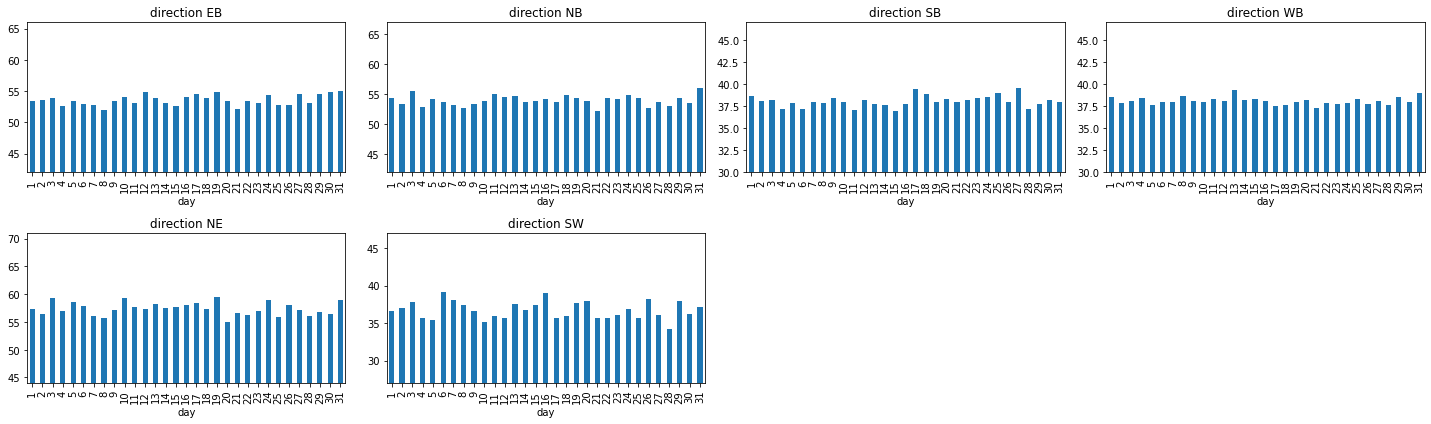

==== location: x1 y1 ====


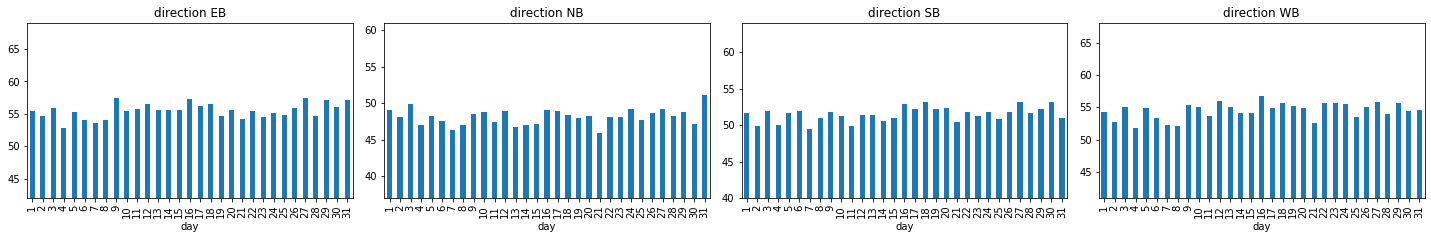

==== location: x1 y2 ====


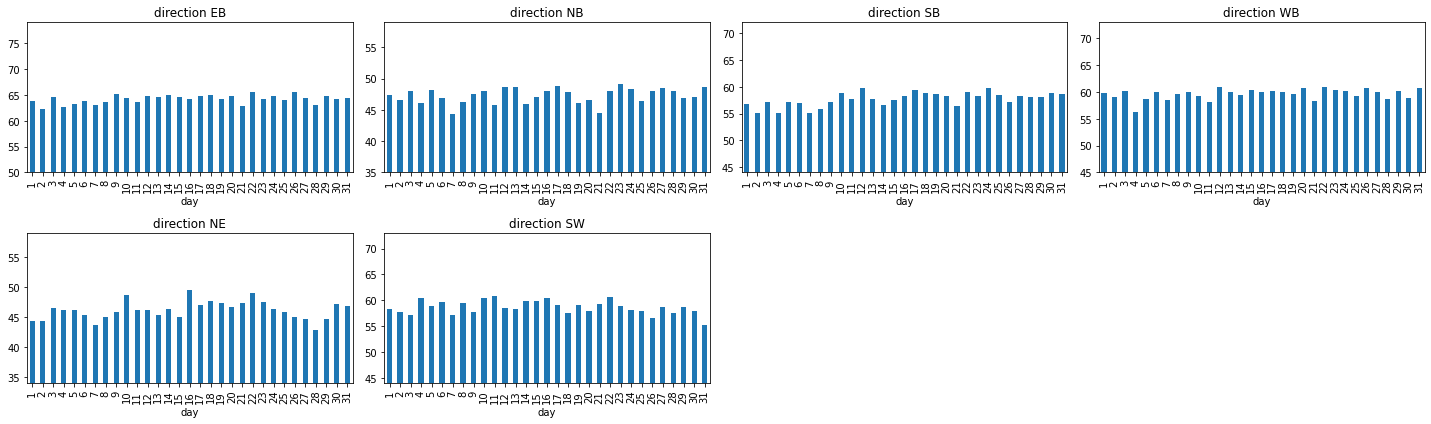

==== location: x1 y3 ====


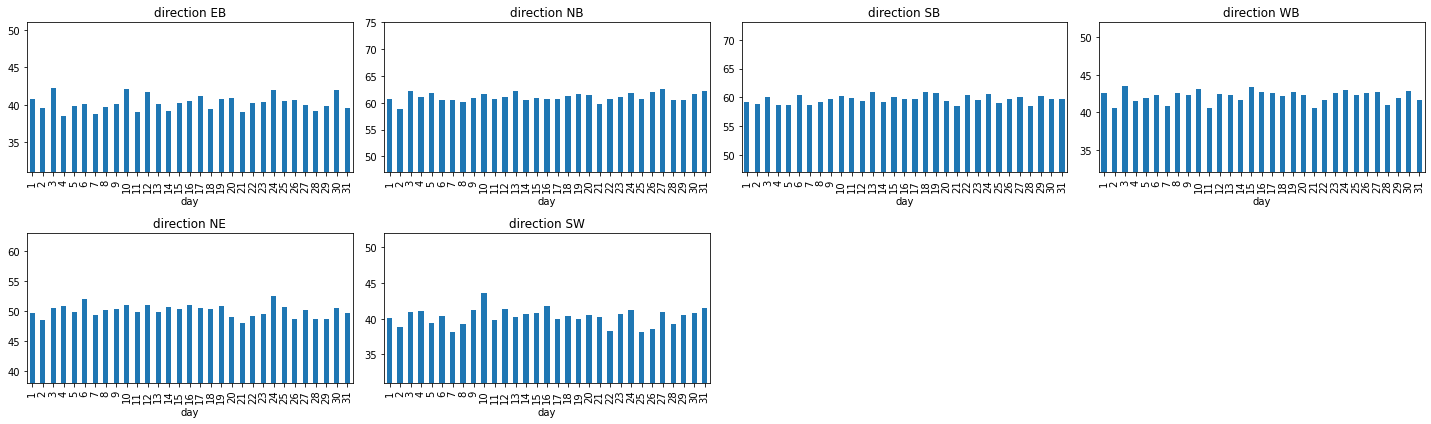

==== location: x2 y0 ====


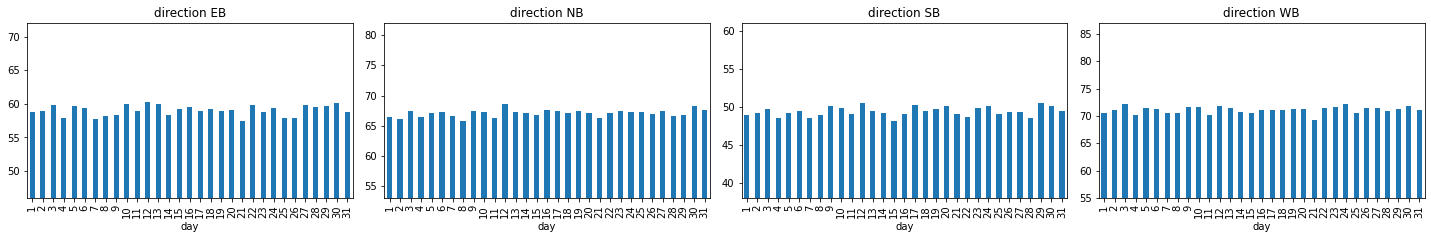

==== location: x2 y1 ====


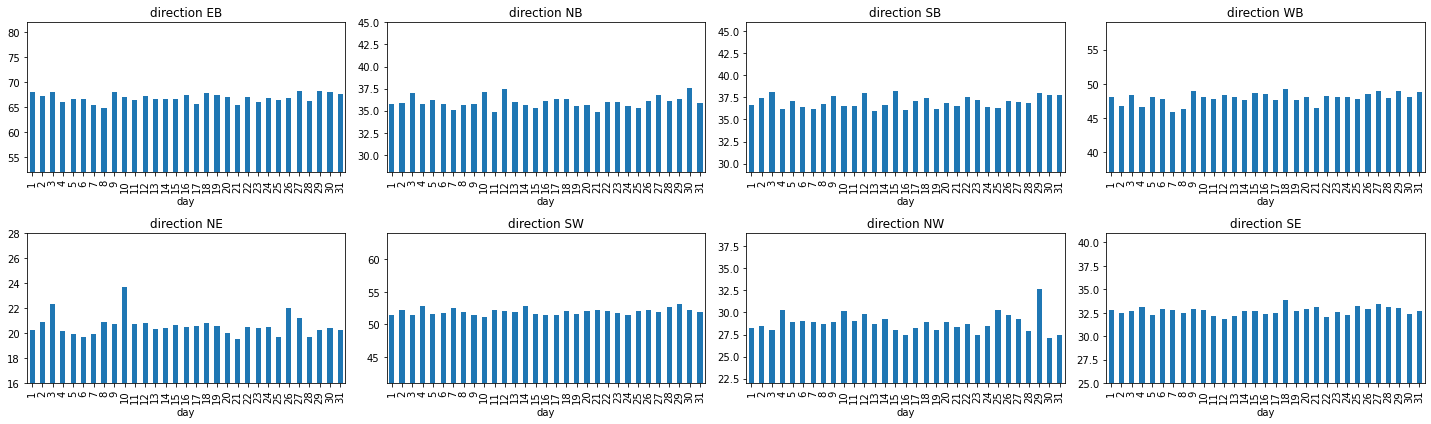

==== location: x2 y2 ====


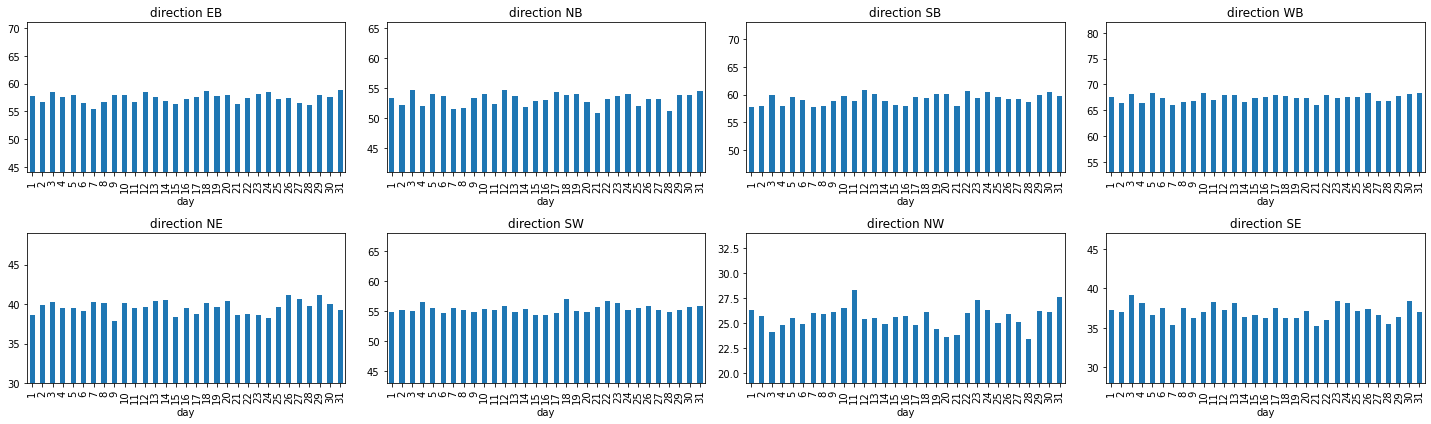

==== location: x2 y3 ====


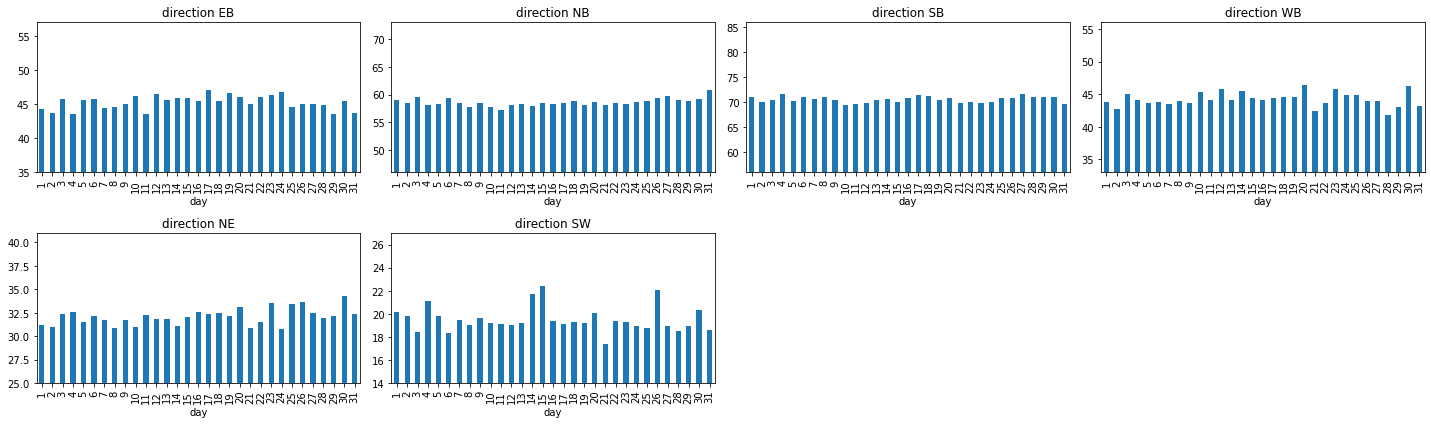

In [ ]:
for x in xs:
    for y in ys:
        print("==== location: x{} y{} ====".format(x, y))
        plt.figure(figsize=(20, 6))
        for i, dir in enumerate(direction):
            df = train[(train.x == x) & (train.y == y) & (train.direction == dir)].groupby("day").congestion.mean()
            if df.shape[0] == 0:
                continue

            plt.subplot(2, 4, i+1)
            df.plot(kind="bar")
            plt.title("direction {}".format(dir))
            plt.ylim(round(df.min()*0.8), round(df.max()*1.2))
        plt.tight_layout()
        plt.show()

### Average congestion per hour each location and direction

==== location: x0 y0 ====


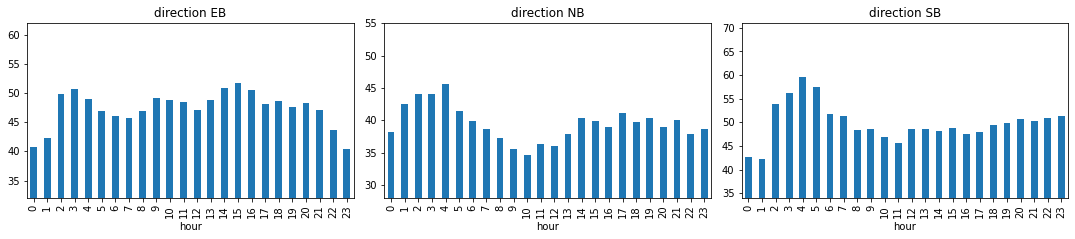

==== location: x0 y1 ====


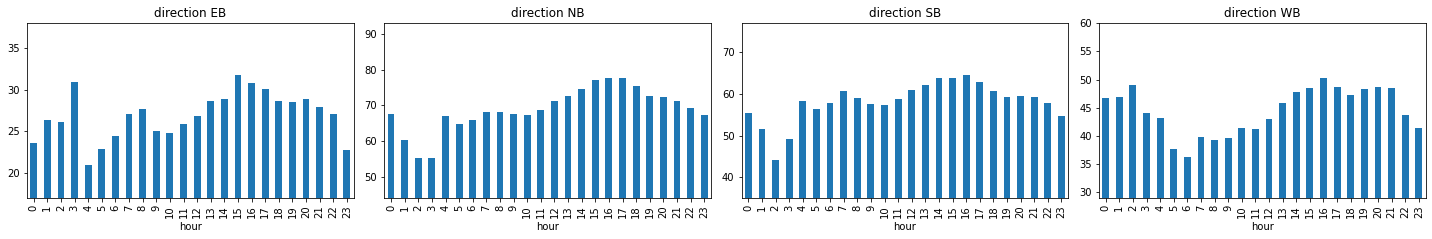

==== location: x0 y2 ====


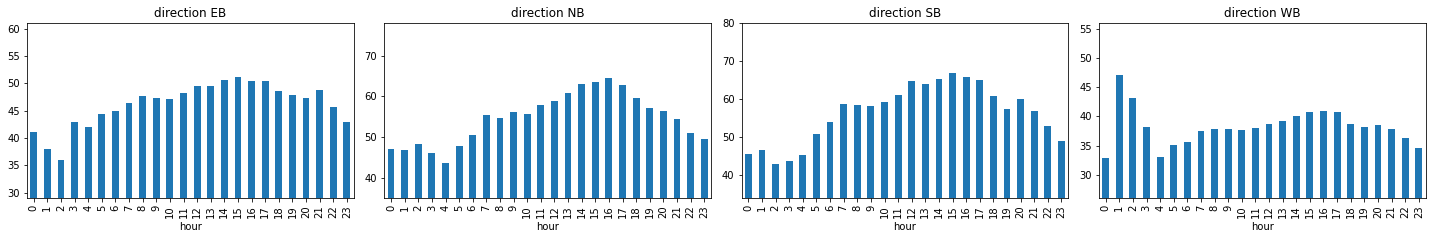

==== location: x0 y3 ====


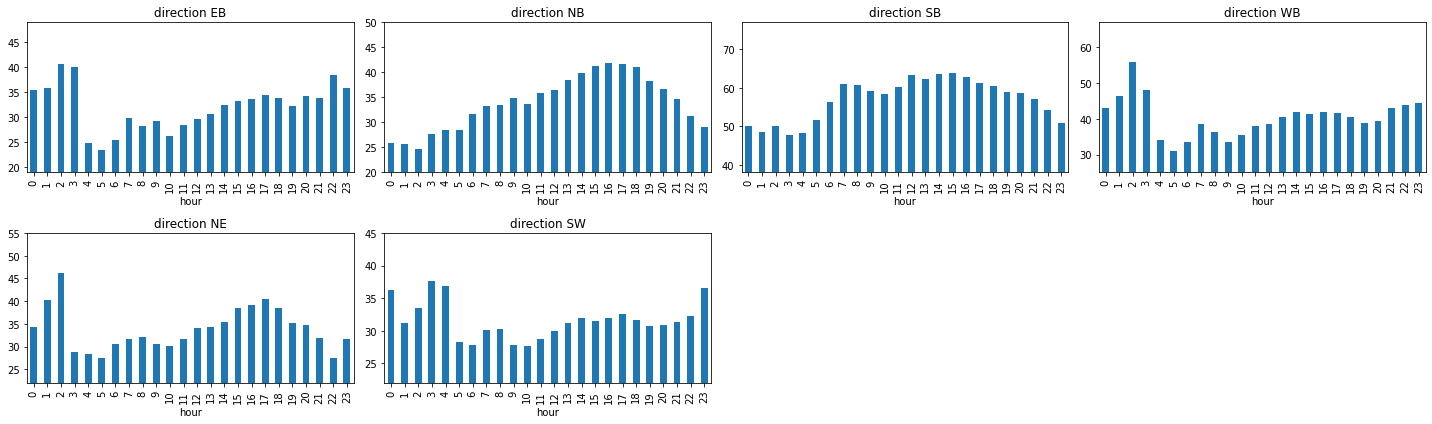

==== location: x1 y0 ====


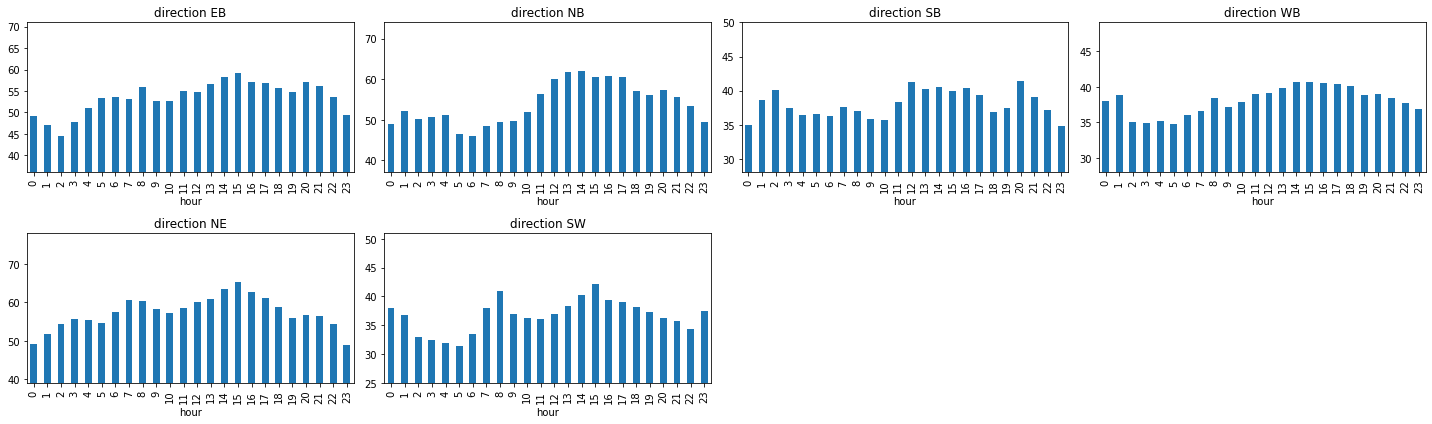

==== location: x1 y1 ====


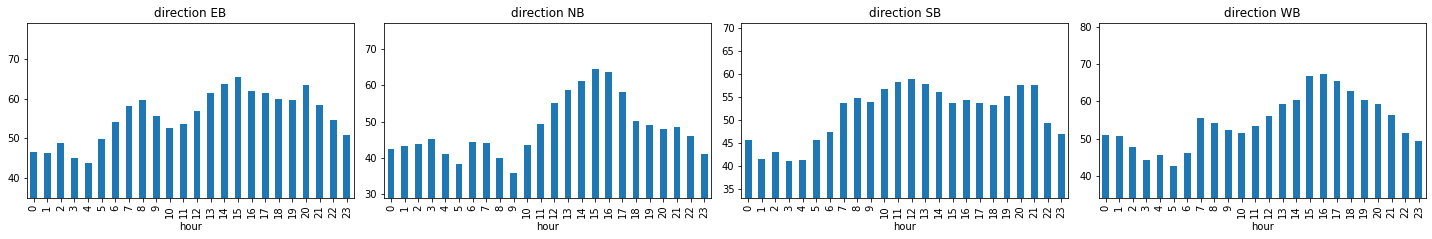

==== location: x1 y2 ====


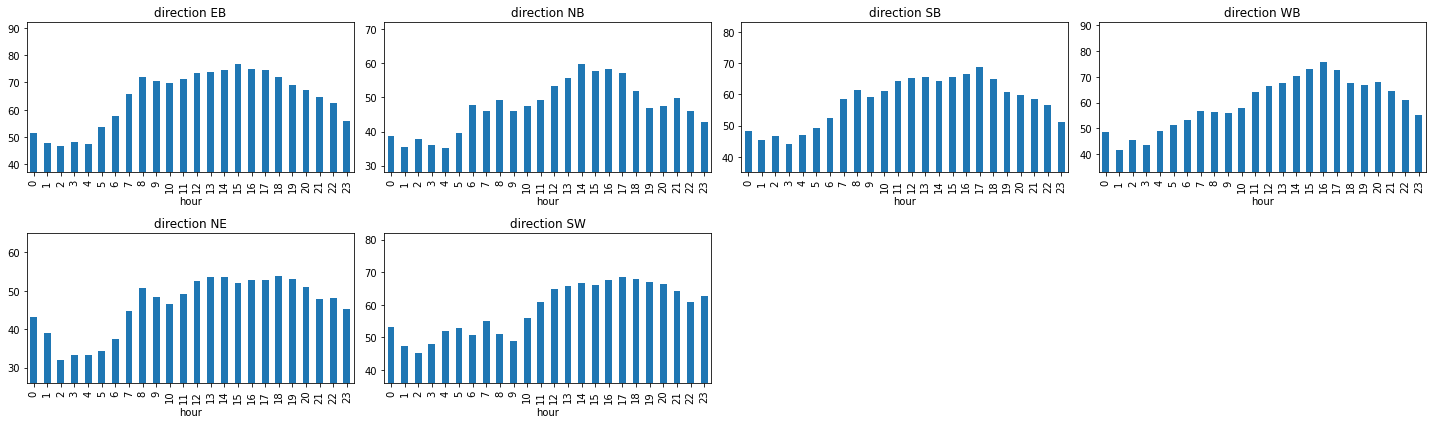

==== location: x1 y3 ====


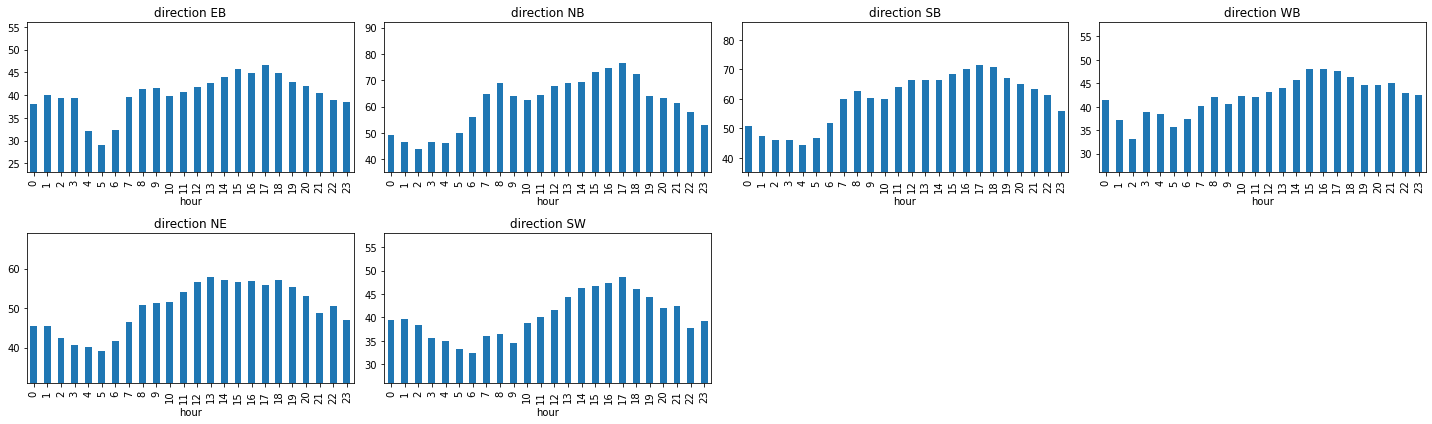

==== location: x2 y0 ====


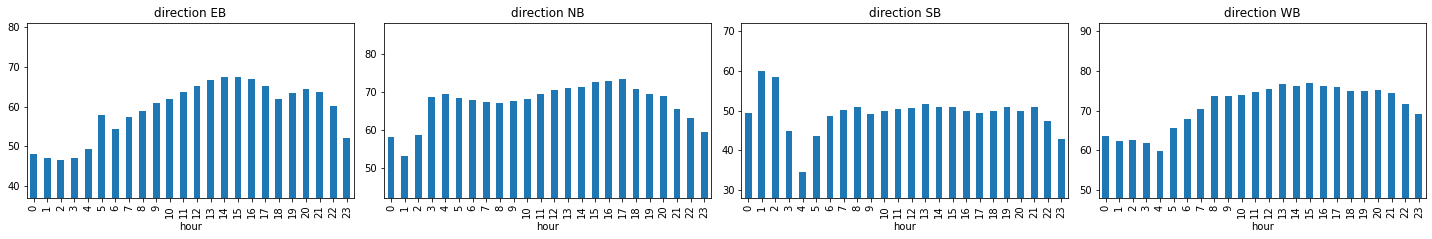

==== location: x2 y1 ====


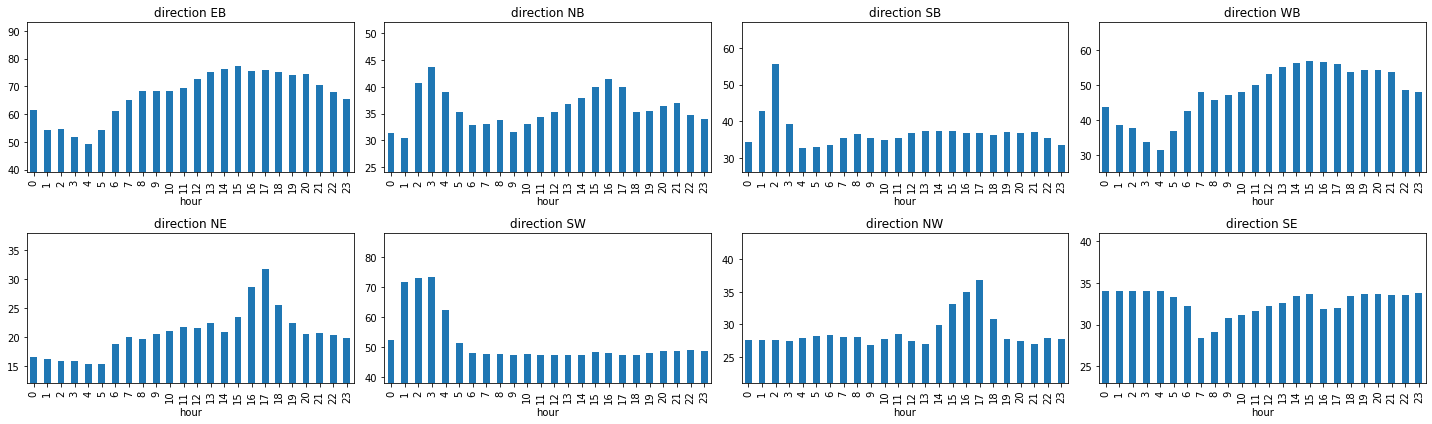

==== location: x2 y2 ====


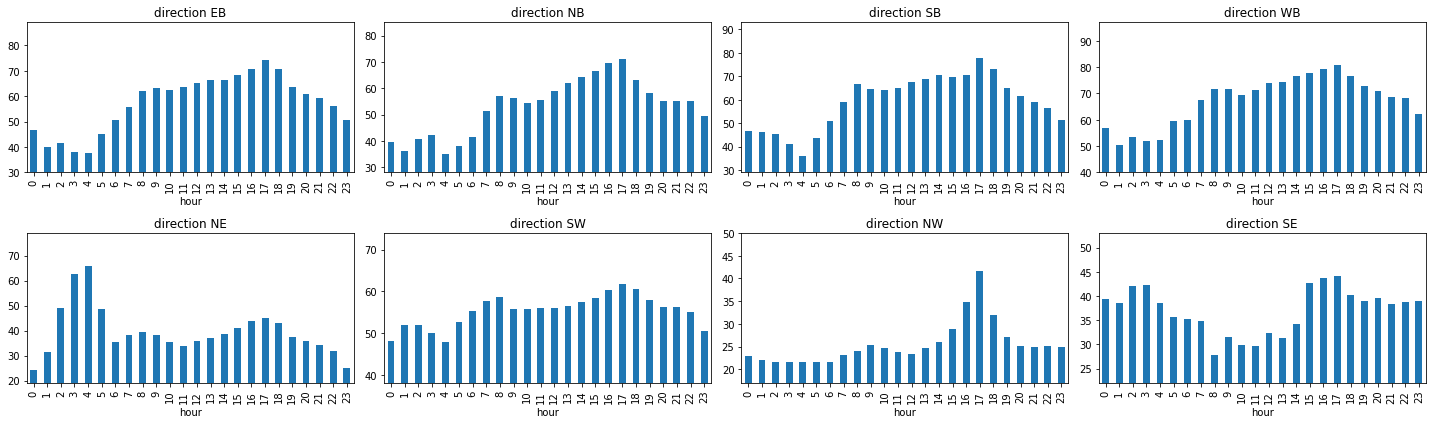

==== location: x2 y3 ====


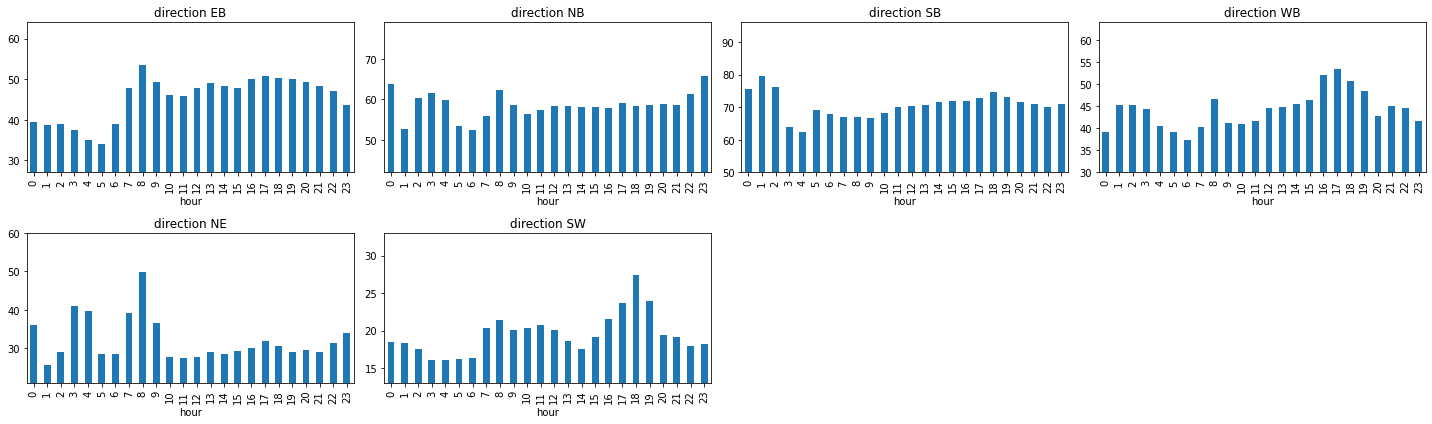

In [ ]:
for x in xs:
    for y in ys:
        print("==== location: x{} y{} ====".format(x, y))
        plt.figure(figsize=(20, 6))
        for i, dir in enumerate(direction):
            df = train[(train.x == x) & (train.y == y) & (train.direction == dir)].groupby("hour").congestion.mean()
            if df.shape[0] == 0:
                continue

            plt.subplot(2, 4, i+1)
            df.plot(kind="bar")
            plt.title("direction {}".format(dir))
            plt.ylim(round(df.min()*0.8), round(df.max()*1.2))
        plt.tight_layout()
        plt.show()

### wide format analysis

In [3]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")

train.time = pd.to_datetime(train.time)
test.time = pd.to_datetime(test.time)

In [10]:
x = train.x.unique().tolist()
y = train.y.unique().tolist()
direction = train.direction.unique().tolist()

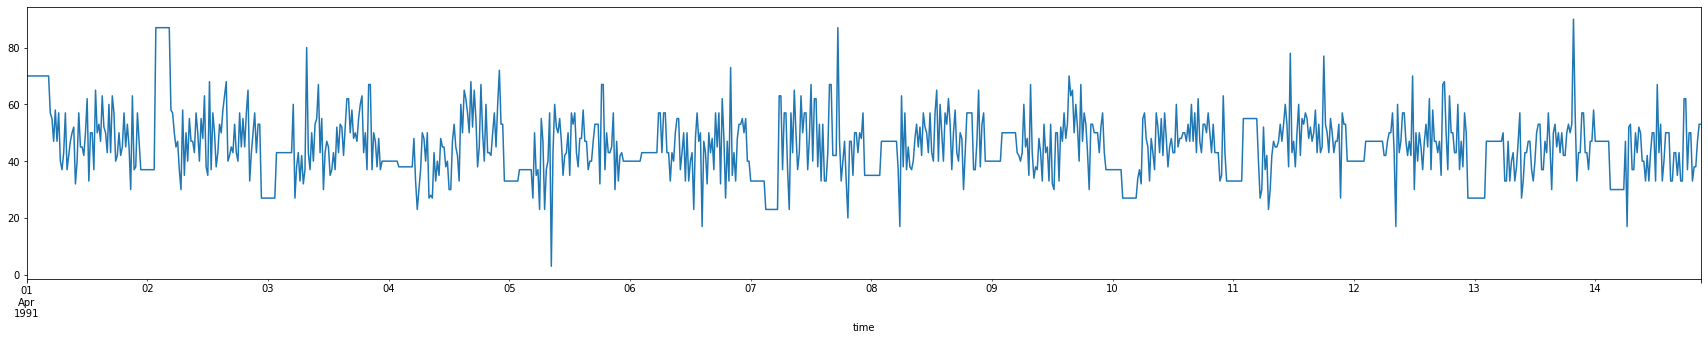